# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

#### 

The data we have comes from 17 marketing campaigns that happened between May 2008 and November 2010. These campaigns were carried out by the bank, and in total, they involved contacting 79,354 people.

From the paper's "Experiments and Results" section reveals that the study involved three main phases of testing on the marketing campaign data:

1. First Phase: In the initial stage, the researchers used the Naive Bayes algorithm on the original data, which had 12 possible output values. They were able to create a basic model, but its performance was limited.

2. Second Phase: In the next stage, they refined the output to a simple classification, categorizing outcomes as either successful or unsuccessful. They tested this modified data with both Naive Bayes and Decision Tree algorithms, which improved performance, although there was still room for enhancement.

3. Third Phase: In the final phase, they conducted a thorough analysis that reduced the input features from 59 to 29. They also removed instances with missing values. This time, they tested the Naive Bayes, Decision Trees, and SVM (Support Vector Machine) algorithms. The SVM algorithm yielded the best results, achieving an AUC (Area Under the Curve) of 0.938 and an ALIFT (AUC Lift) of 0.887.

In summary:

- The study comprised three distinct testing phases.
- In the third phase, they evaluated the performance of Naive Bayes, Decision Tree, and SVM models.
- Among these models, the SVM model stood out as the most accurate in predicting the success of marketing contacts.

These experiments showcase a systematic approach (CRISP-DM) to improving model performance by understanding the data, streamlining it, and experimenting with various algorithms. Ultimately, the SVM model excelled in accurately predicting the success of marketing interactions.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
import time
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [12]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
# Find missing values in each column
missing_values = df.isnull().sum()

# Check and print the results
missing_columns = missing_values[missing_values > 0]

if missing_columns.empty:
    print("######################################")
    print("No missing values in the dataset")
    print("######################################")
else:
    print("######################################")
    print("Columns with missing values:")
    print(missing_columns)
    print("######################################")

# Count unique values in non-numeric column

# Get the non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number'])
print("\n")
print("######################################")
print("Unique Values Count for" , len(non_numeric_columns.columns) , "non-numeric columns")
print("######################################")

# Calculate and print the unique value counts for non-numeric columns
for column in non_numeric_columns.columns:
    unique_values_count = non_numeric_columns[column].nunique()
    print(f"Column '{column}' has {unique_values_count} unique values.")


print("\n")
# Describing the data
print("########################  Describing the data ###########################")
print(df.describe().T)
print("#########################################################################")

print("\n")
# Understanding if there is any imbalance in the target variable
print("##########################  Class Imbalance of Target variable  ############################")
print(df['y'].value_counts() ,  '  And the ratio is  ' , (df['y'] == 'no').sum()/(df['y'] == 'yes').sum())
print("#############################################################################################")

######################################
No missing values in the dataset
######################################


######################################
Unique Values Count for 11 non-numeric columns
######################################
Column 'job' has 12 unique values.
Column 'marital' has 4 unique values.
Column 'education' has 8 unique values.
Column 'default' has 3 unique values.
Column 'housing' has 3 unique values.
Column 'loan' has 3 unique values.
Column 'contact' has 2 unique values.
Column 'month' has 10 unique values.
Column 'day_of_week' has 5 unique values.
Column 'poutcome' has 3 unique values.
Column 'y' has 2 unique values.


########################  Describing the data ###########################
                  count         mean         std       min       25%  \
age             41188.0    40.024060   10.421250    17.000    32.000   
duration        41188.0   258.285010  259.279249     0.000   102.000   
campaign        41188.0     2.567593    2.770014     1.000

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Main Objective: To develop a predictive model using data mining techniques that can determine the likelihood of a customer subscribing to a long-term deposit product as part of a direct marketing campaign by the bank.

Shape before deleting the duplicates from dataset (41188, 21)
Shape after deleting the duplicates from dataset (41176, 21)
Dropping the duration column as mentioned in the column description


################## Correlation of the matrix ####################


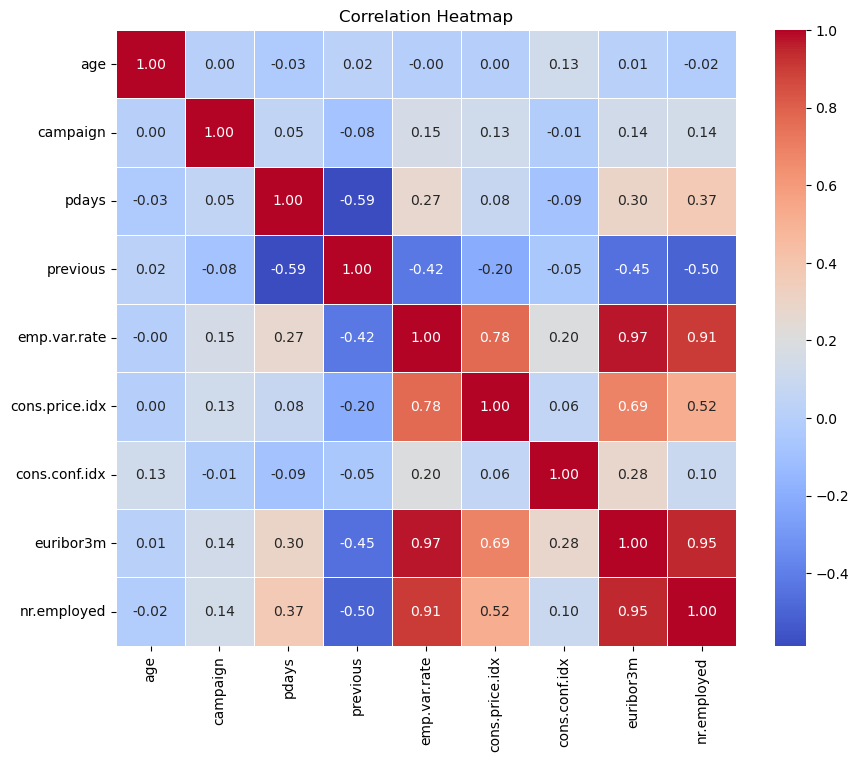

In [13]:
print("Shape before deleting the duplicates from dataset", df.shape)
df.drop_duplicates(inplace=True)
print("Shape after deleting the duplicates from dataset", df.shape)

print("Dropping the duration column as mentioned in the column description")
df.drop('duration', axis=1, inplace=True)


print("\n")
print("################## Correlation of the matrix ####################")
cormat=df.corr(numeric_only=True)
# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(cormat, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

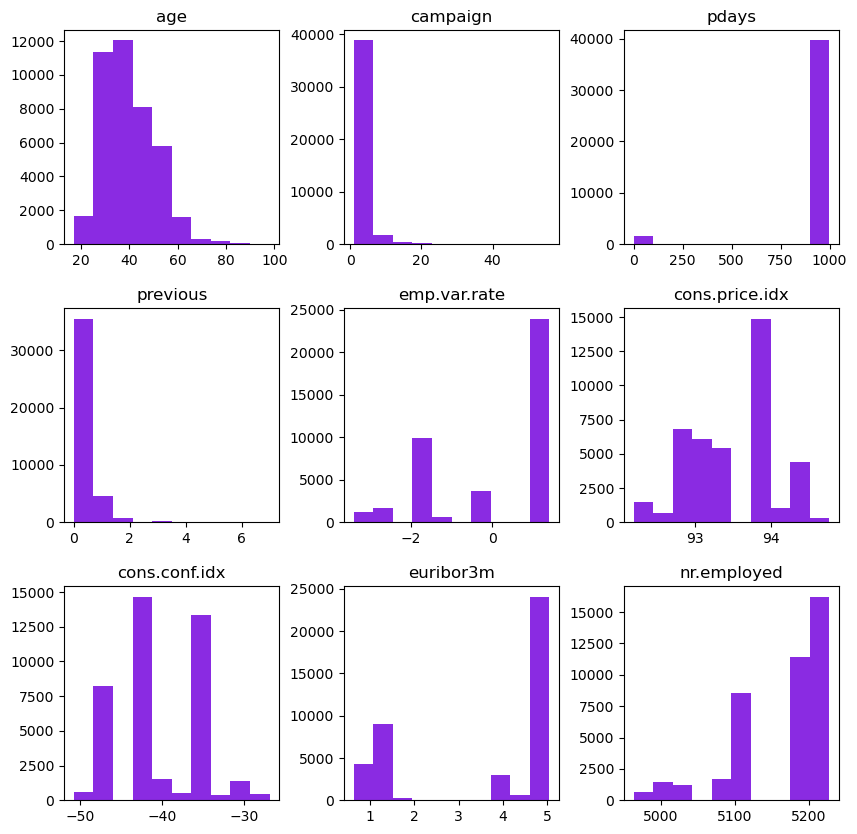

In [7]:
## Want to determine which features are dependent mainly on the prediction 

# Ploting histogram to check that if data columns are normal or almost normal or not
df.hist(figsize=(10,10),color="blueviolet",grid=False)
plt.show()



### Understanding the relation of features with the target variable 'y'

In [8]:

class UnderstandingData:
    
    def __init__(self, raw_df):
        self.raw_df = raw_df
        self.raw_df_grouped = raw_df.groupby("y")
        self.class_name_no = "no"
        self.class_name_yes = "yes"
        self.raw_df_grouped_no = self.raw_df_grouped.get_group(self.class_name_no)
        self.raw_df_grouped_yes = self.raw_df_grouped.get_group(self.class_name_yes)

    def plot_histogram_continuous(self, feature_name, bin_size):
        plt.figure()
        plt.hist(self.raw_df_grouped_no[feature_name], bins=bin_size, label=self.class_name_no)
        plt.hist(self.raw_df_grouped_yes[feature_name], bins=bin_size, label=self.class_name_yes)
        plt.legend()
        plt.title("Feature Histogram - "+feature_name)
        plt.xlabel("Feature values")
        plt.ylabel("Count")

    def plot_histogram_categorical(self, feature_name):
        feature_df = pd.DataFrame()
        feature_df["no"] = self.raw_df_grouped_no[feature_name].value_counts()
        feature_df["yes"] = self.raw_df_grouped_yes[feature_name].value_counts()
        
        feature_df.plot(kind='bar')
        plt.title("Feature Histogram - "+feature_name)
        plt.ylabel("Count")
        plt.xlabel("Feature unique values")
        plt.tight_layout()

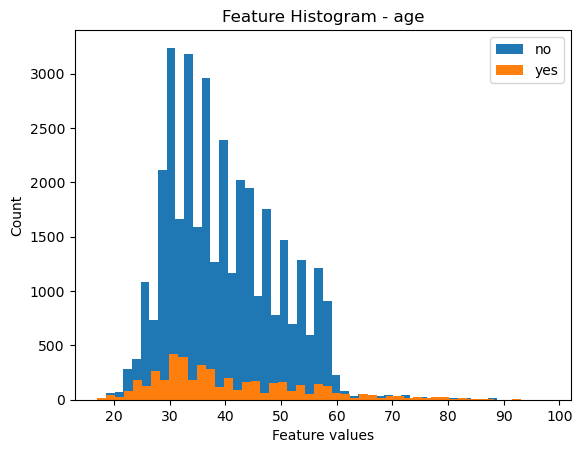

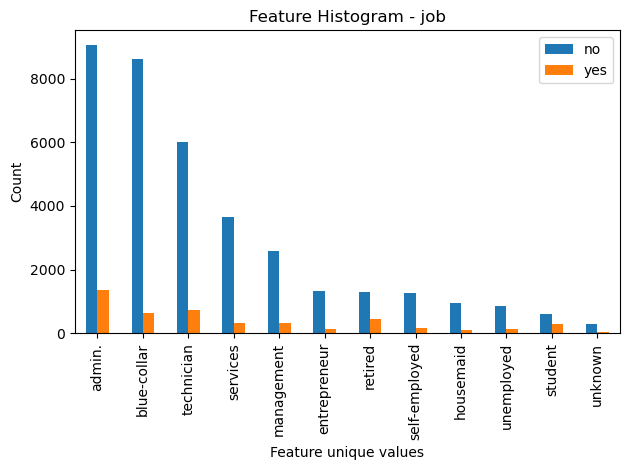

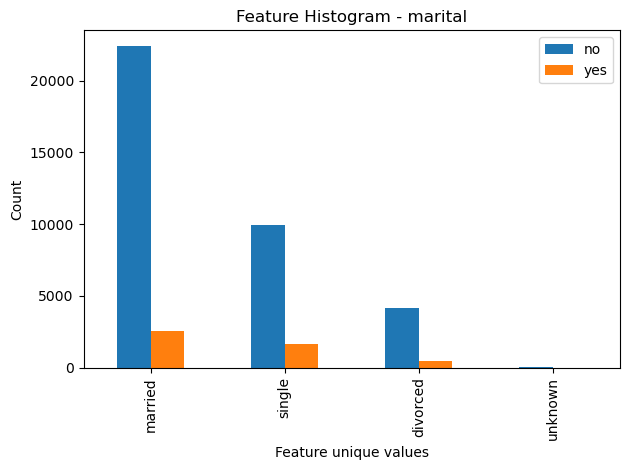

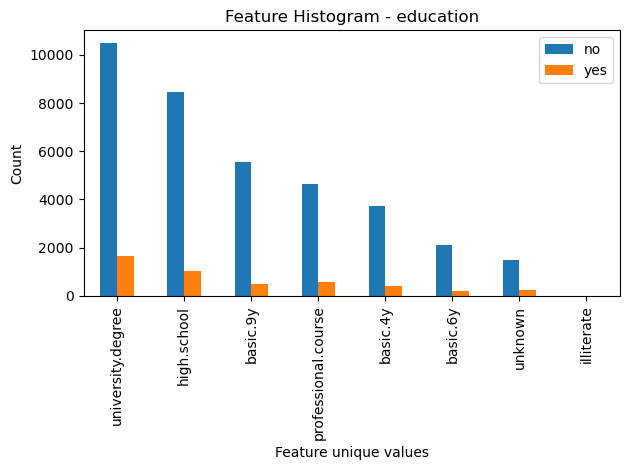

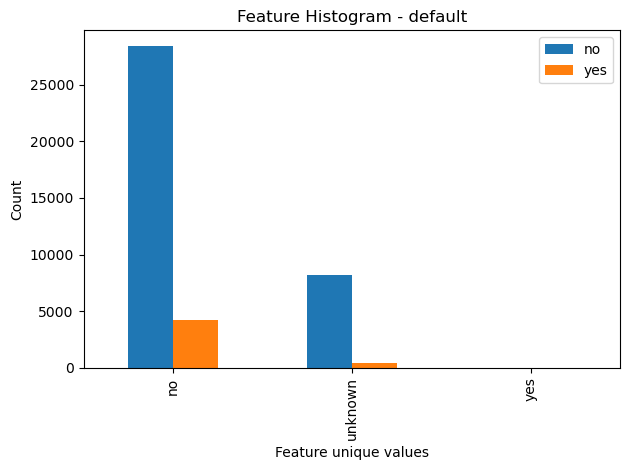

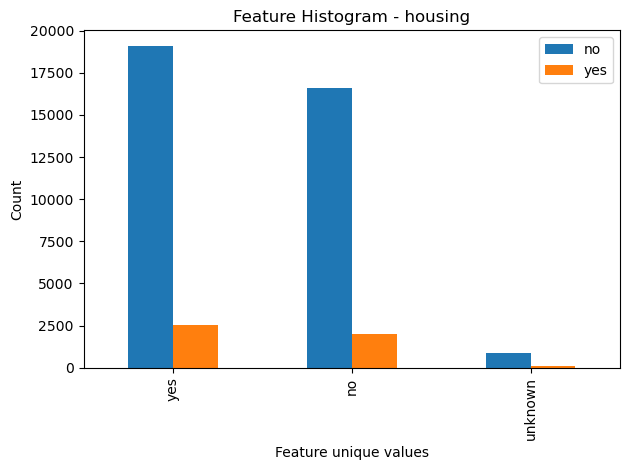

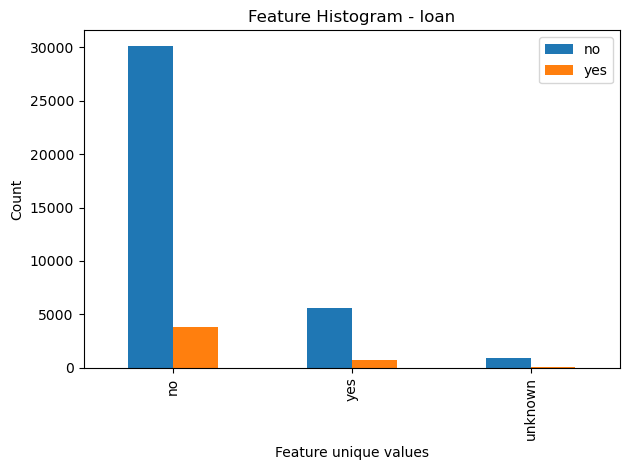

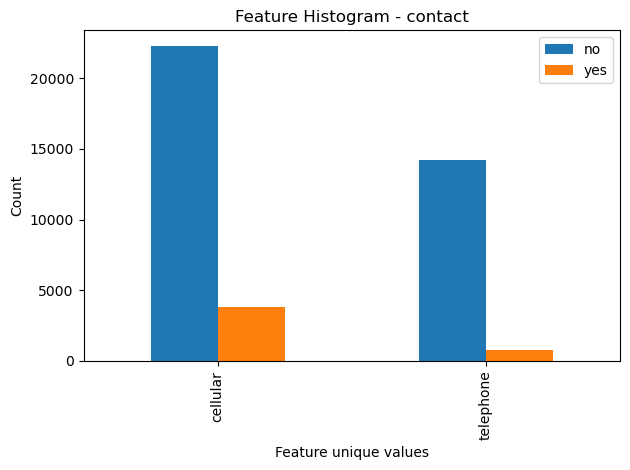

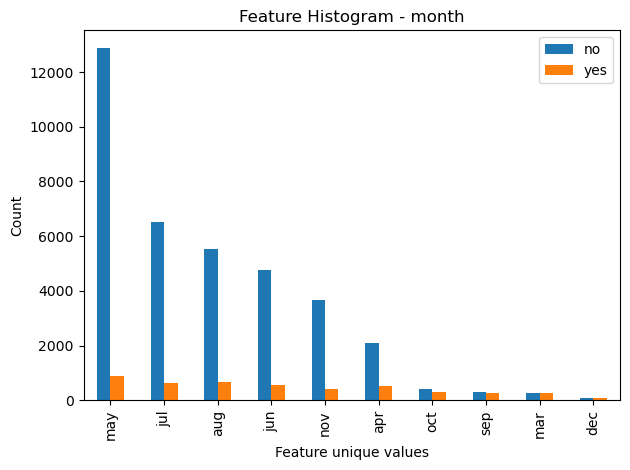

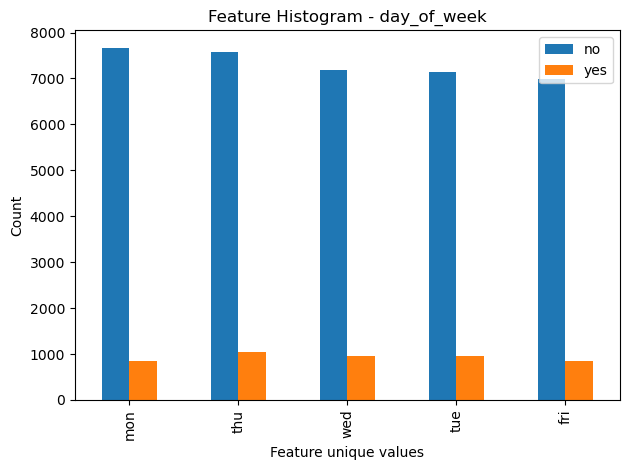

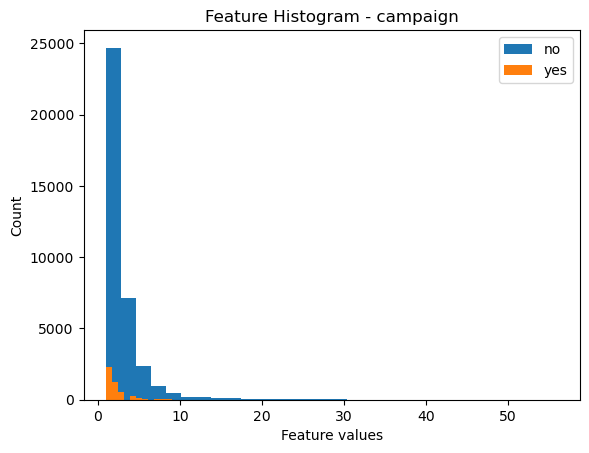

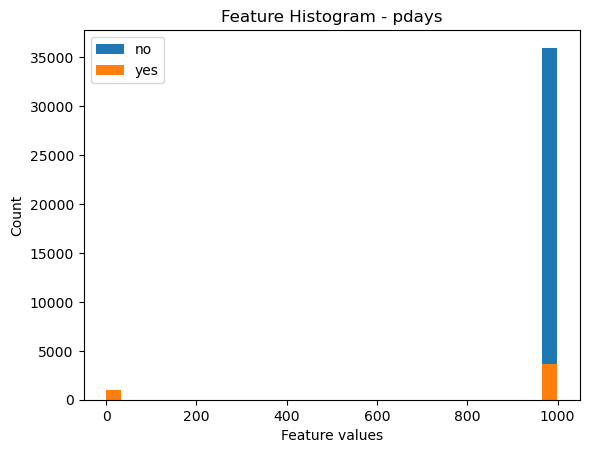

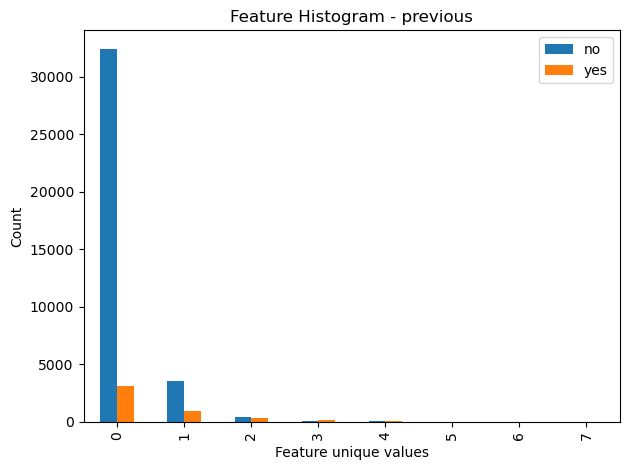

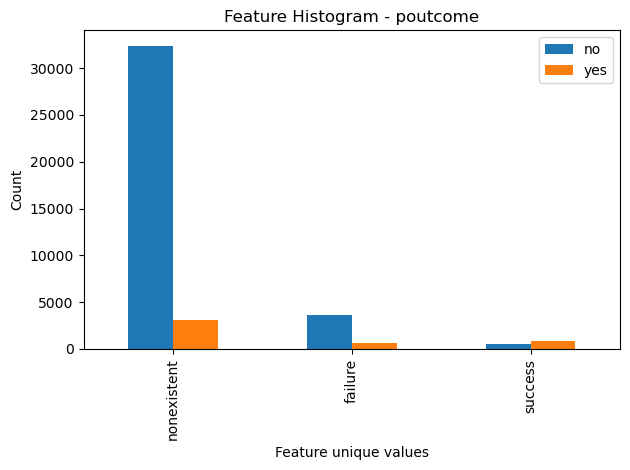

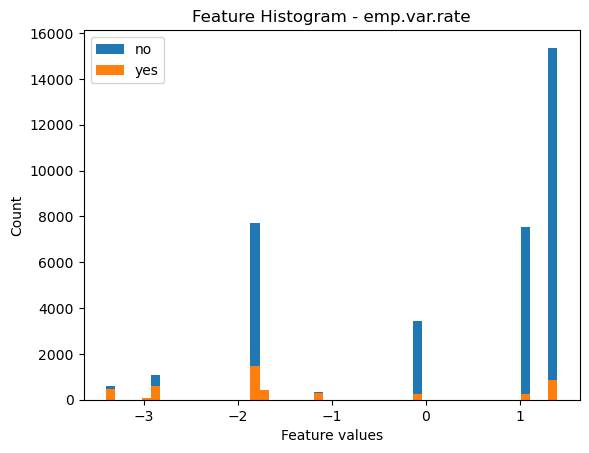

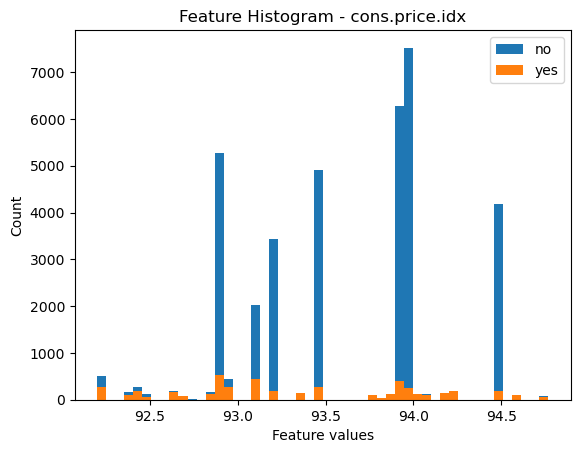

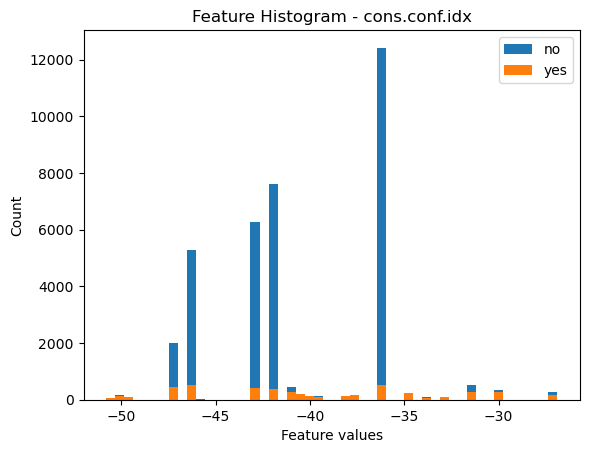

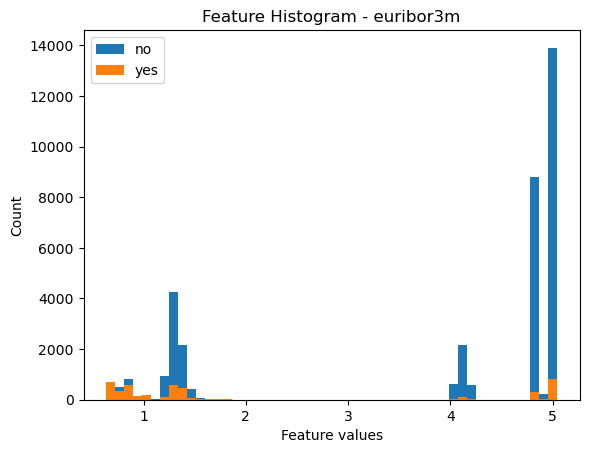

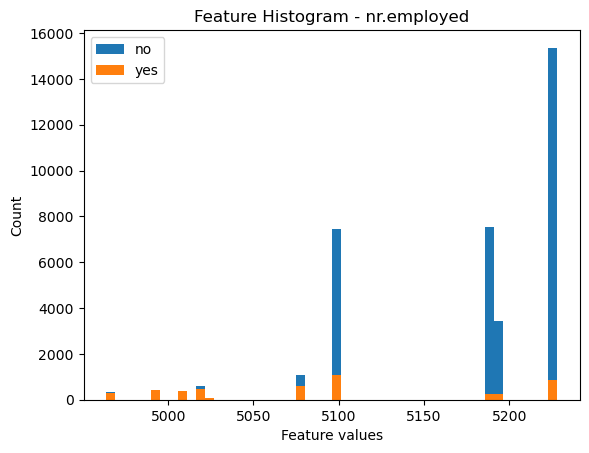

In [9]:
understanding_data = UnderstandingData(df)

### Feature 1 - AGE
understanding_data.plot_histogram_continuous("age", 50)

### Feature 2 - JOB
understanding_data.plot_histogram_categorical("job")

### Feature 3 - MARITAL
understanding_data.plot_histogram_categorical("marital")

### Feature 4 - EDUCATION
understanding_data.plot_histogram_categorical("education")

### Feature 5 - DEFAULT
understanding_data.plot_histogram_categorical("default")

### Feature 6 - HOUSING
understanding_data.plot_histogram_categorical("housing")

### Feature 7 - LOAN
understanding_data.plot_histogram_categorical("loan")

### Feature 8 - CONTACT
understanding_data.plot_histogram_categorical("contact")

### Feature 9 - MONTH
understanding_data.plot_histogram_categorical("month")

### Feature 10 - DAY OF WEEK
understanding_data.plot_histogram_categorical("day_of_week")

### Feature 11 - CAMPAIGN
understanding_data.plot_histogram_continuous("campaign", 30)

### Feature 12 - PDAYS
understanding_data.plot_histogram_continuous("pdays", 30)

### Feature 13 - PREVIOUS
understanding_data.plot_histogram_categorical("previous")

### Feature 14 - POUTCOME
understanding_data.plot_histogram_categorical("poutcome")

### Feature 15 - emp.var.rate
understanding_data.plot_histogram_continuous("emp.var.rate", 50)

### Feature 16 - cons.price.idx
understanding_data.plot_histogram_continuous("cons.price.idx", 50)

### Feature 17 - cons.conf.idx
understanding_data.plot_histogram_continuous("cons.conf.idx", 50)

### Feature 18 - euribor3m
understanding_data.plot_histogram_continuous("euribor3m", 50)

### Feature 19 - nr.employed
understanding_data.plot_histogram_continuous("nr.employed", 50)


In [14]:
## Trying to find unknown entries
import pandas as pd

# Initialize a dictionary to store column names as keys and the count of 'unknown' values as values
unknown_counts = {}

# Loop through each column in the DataFrame
for column in df.columns:
    # Check if the column contains 'unknown' values and count them
    unknown_count = df[df[column] == 'unknown'].shape[0]
    
    # If there are 'unknown' values in the column, store the count in the dictionary
    if unknown_count > 0:
        unknown_counts[column] = unknown_count

# Print the columns with 'unknown' values and their respective counts
for column, count in unknown_counts.items():
    print(f"Column '{column}' has {count} 'unknown' values.")

# Create a boolean mask where "unknown" values are present in any column
mask = df.apply(lambda x: x.str.contains('unknown').any(), axis=1)

# Filter the DataFrame to include only rows where "unknown" values are present in any column
rows_with_unknown = df[mask]

# Calculate the total number of rows
total_rows_with_unknown = len(rows_with_unknown)

print(f"Total number of rows with 'unknown' values in any column: {total_rows_with_unknown}")

#print("Default column details\n", df['default'].value_counts())



Column 'job' has 330 'unknown' values.
Column 'marital' has 80 'unknown' values.
Column 'education' has 1730 'unknown' values.
Column 'default' has 8596 'unknown' values.
Column 'housing' has 990 'unknown' values.
Column 'loan' has 990 'unknown' values.
Total number of rows with 'unknown' values in any column: 10698


### Observations from the graphs and unknowns.

Some Important features/observations are

1. Jobs -  we can see that the customers who have a job of admin have the highest rate of subscribing a term deposit, but they are also the highest when it comes to not subscribing.
2. Education - Playing a role
3. Months - Some months are more favorable, may be a seasonal effect ?
4. Age - Average age of the person
5. Previous outcomes
6. Day of the week -> Data is equally distributed across all the days and the outcomes as well, so we can drop the column as well
7. Default -> It has more 'no' and around 8500 unknowns and has only 3 'yes', hence dropping that column as well for the training

In [15]:
print("Dropping the day_of_week and default columns as mentioned in the column description")
df.drop(['default', 'day_of_week'], axis=1, inplace=True)
print("DF shape after dropping the columns ", df.shape)
print("Dropping the rows with any unknowns in any columns")
# Drop rows with "unknown" values in any column
# Drop rows with "unknown" values in any column
df = df[~df.apply(lambda row: row.str.contains('unknown').any(), axis=1)]
print("DF shape after dropping the unknowns ", df.shape)


Dropping the day_of_week and default columns as mentioned in the column description
DF shape after dropping the columns  (41176, 18)
Dropping the rows with any unknowns in any columns
DF shape after dropping the unknowns  (38234, 18)


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [16]:
# Converting the categorical columns to numeric columns by using the get_dummies

df1=df.copy()

cat_cols = ['job','marital','education','housing','loan','contact','month','poutcome']

for col in cat_cols:
    df1 = df1.join(pd.get_dummies(df1[col],prefix = col))

keep = [col for col in df1.columns if col not in cat_cols]
df1 = df1 [keep]

df1.shape
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38234 entries, 0 to 41187
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            38234 non-null  int64  
 1   campaign                       38234 non-null  int64  
 2   pdays                          38234 non-null  int64  
 3   previous                       38234 non-null  int64  
 4   emp.var.rate                   38234 non-null  float64
 5   cons.price.idx                 38234 non-null  float64
 6   cons.conf.idx                  38234 non-null  float64
 7   euribor3m                      38234 non-null  float64
 8   nr.employed                    38234 non-null  float64
 9   y                              38234 non-null  object 
 10  job_admin.                     38234 non-null  uint8  
 11  job_blue-collar                38234 non-null  uint8  
 12  job_entrepreneur               38234 non-null 

In [19]:
df1["y"]=df1.y.astype('category')
df1["y"]=df1["y"].cat.codes

df_encoded = df1

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [20]:
#Store target column 
y = df_encoded['y'] 

# Drop target column from df
X = df_encoded.drop(['y'], axis=1)  
print(X.shape, y.shape)

(38234, 49) (38234,)


In [21]:
# Splitting the data into test and training datasets with test size 30% and random state of 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (26763, 49)
Number transactions y_train dataset:  (26763,)
Number transactions X_test dataset:  (11471, 49)
Number transactions y_test dataset:  (11471,)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [22]:
# Normalizing the Target variable and creating a baseline prediction with class type that has maximum entries of Target variable

target_dist = df['y'].value_counts(normalize=True)
print(target_dist)
baseline_pred = [target_dist.index[0]] * len(df)
baseline_accuracy = accuracy_score(df['y'], baseline_pred)
print("Baseline accuracy:", baseline_accuracy)

no     0.888659
yes    0.111341
Name: y, dtype: float64
Baseline accuracy: 0.8886593084689021


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

Accuracy of the basic logistic regression 0.900880481213495

Classification report

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10165
           1       0.71      0.22      0.33      1306

    accuracy                           0.90     11471
   macro avg       0.81      0.60      0.64     11471
weighted avg       0.89      0.90      0.88     11471



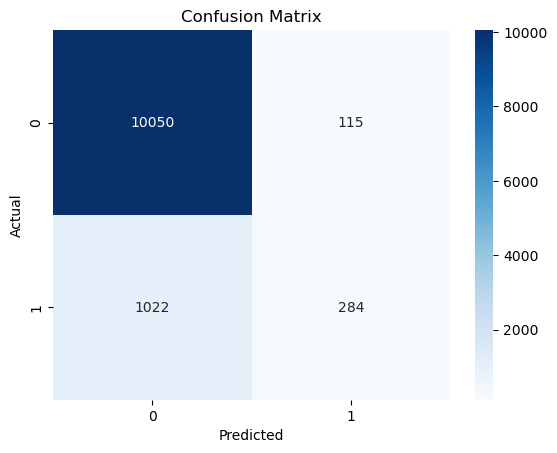

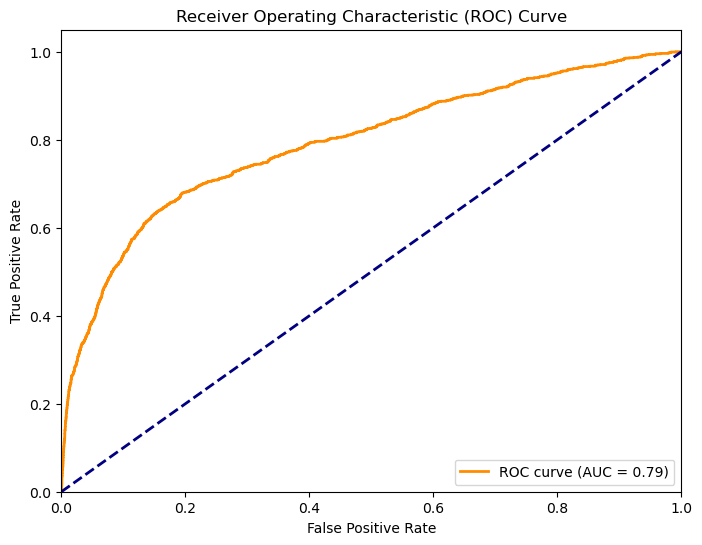

In [23]:
#Logistic regression - simple model

base_lr_model=LogisticRegression(max_iter=1000)

# Calculating the time
start_time = time.time()
base_lr_model.fit(X_train,y_train)
train_time = time.time() - start_time

# Predictions and accuracy score
y_pred=base_lr_model.predict(X_test)
train_acc = base_lr_model.score(X_train, y_train)
test_acc = accuracy_score(y_test, y_pred)

print("Accuracy of the basic logistic regression" ,accuracy_score(y_test,y_pred))


# Create the confusion matrix heatmap
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

print("\nClassification report\n")
print(classification_report(y_test,y_pred))

# ROC Curve

y_prob = base_lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Problem 9: Score the Model

What is the accuracy of your model?

In [63]:
print("Accuracy of the basic logistic regression" ,accuracy_score(y_test,y_pred))

Accuracy of the basic logistic regression 0.900880481213495


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [69]:
# Calculating the Test and Train accuracy of classification models with default settings

results = pd.DataFrame(columns=["Model", "Train Time", "Train Accuracy", "Test Accuracy"])

#Appending the Logistis regression results
results = results.append({"Model": "Logistic Regression", "Train Time": train_time, "Train Accuracy": train_acc, "Test Accuracy": test_acc}, ignore_index=True)

# K-Nearest Neighbors (KNN) with time and accuracy calculations

knn_model = KNeighborsClassifier()
start_time = time.time()
knn_model.fit(X_train, y_train)
train_time = time.time() - start_time
y_pred = knn_model.predict(X_test)
train_acc = knn_model.score(X_train, y_train)
test_acc = accuracy_score(y_test, y_pred)
results = results.append({"Model": "KNN", "Train Time": train_time, "Train Accuracy": train_acc, "Test Accuracy": test_acc}, ignore_index=True)

# Decision Tree with time and accuracy calculations

dt_model = DecisionTreeClassifier()
start_time = time.time()
dt_model.fit(X_train, y_train)
train_time = time.time() - start_time
y_pred = dt_model.predict(X_test)
train_acc = dt_model.score(X_train, y_train)
test_acc = accuracy_score(y_test, y_pred)
results = results.append({"Model": "Decision Tree", "Train Time": train_time, "Train Accuracy": train_acc, "Test Accuracy": test_acc}, ignore_index=True)

# Support Vector Machine (SVM) with time and accuracy calculations

svm_model = SVC()
start_time = time.time()
svm_model.fit(X_train, y_train)
train_time = time.time() - start_time
y_pred = svm_model.predict(X_test)
train_acc = svm_model.score(X_train, y_train)
test_acc = accuracy_score(y_test, y_pred)
results = results.append({"Model": "SVM", "Train Time": train_time, "Train Accuracy": train_acc, "Test Accuracy": test_acc}, ignore_index=True)

print(results)



                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression   10.912539        0.898666       0.897045
1                  KNN    0.022354        0.913351       0.888589
2        Decision Tree    0.263858        0.994993       0.839944
3                  SVM   11.861111        0.898666       0.897045


### Summary of Basic model comparisons.



**Logistic Regression**: This model achieved a test accuracy of approximately 89.70%, with a training time of about 10.91 seconds. The training accuracy was also high at 89.87%. Notably, it outperformed the baseline accuracy of approximately 88.87%.

**K-Nearest Neighbors (KNN)**: KNN demonstrated a test accuracy of around 88.86%, with a fast training time of approximately 0.02 seconds. The training accuracy was slightly higher at 91.34%.

**Decision Tree**: The Decision Tree model, while achieving a high training accuracy of approximately 99.50%, had a lower test accuracy of around 83.99%. It should be noted that this test accuracy was lower than the baseline accuracy.

**Support Vector Machine (SVM)**: Similar to Logistic Regression, the SVM model achieved a test accuracy of roughly 89.70%. It had a training time of approximately 11.86 seconds, and the training accuracy matched the test accuracy at 89.87%. The SVM model also outperformed the baseline accuracy.

Each model's test accuracy performed relative to the baseline accuracy of approximately 88.87%.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [73]:
# Hyperparameter tuning for Logistic Regression
lr_model = LogisticRegression()
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'max_iter': [500, 1000],  # Maximum number of iterations
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'saga'],
}
lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5)
lr_grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding scores
print("Best Hyperparameters:", lr_grid_search.best_params_)
print("Best Score:", lr_grid_search.best_score_)



Best Hyperparameters: {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.900982727090714


In [95]:
# Get feature coefficients for linear regression
# Get the best model
best_lr_model = lr_grid_search.best_estimator_
feature_coefficients = best_lr_model.coef_[0]

# Get the feature names from the feature matrix 'X'
feature_names = X.columns

# Create a DataFrame to display feature names and coefficients
feature_coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': feature_coefficients})

# Calculate the absolute values of the coefficients
feature_coef_df['Absolute_Coefficient'] = feature_coef_df['Coefficient'].abs()

# Sort the DataFrame by coefficient values (e.g., in descending order)
feature_coef_df = feature_coef_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Display the DataFrame
print(feature_coef_df)

                          Feature  Coefficient  Absolute_Coefficient
42                      month_may    -0.554820              0.554820
5                  cons.price.idx     0.367000              0.367000
34               contact_cellular     0.263657              0.263657
35              contact_telephone    -0.260975              0.260975
46               poutcome_failure    -0.222289              0.222289
3                        previous    -0.221673              0.221673
39                      month_jul     0.220195              0.220195
47           poutcome_nonexistent     0.195018              0.195018
4                    emp.var.rate    -0.181856              0.181856
41                      month_mar     0.155044              0.155044
29    education_university.degree     0.124336              0.124336
10                job_blue-collar    -0.120005              0.120005
7                       euribor3m    -0.108455              0.108455
14                    job_retired 

In [76]:
# Hyperparameter tuning for K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': range(1, 15),  # Number of neighbors
     'weights': ['uniform', 'distance'],
}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5)
knn_grid_search.fit(X_train, y_train)

print("K-Nearest Neighbors - Best Hyperparameters:", knn_grid_search.best_params_)
print("K-Nearest Neighbors - Best Score:", knn_grid_search.best_score_)


K-Nearest Neighbors - Best Hyperparameters: {'n_neighbors': 14, 'weights': 'uniform'}
K-Nearest Neighbors - Best Score: 0.8967231679594054


In [101]:
results = permutation_importance(knn_grid_search.best_estimator_, X_test, y_test, n_repeats=10, random_state=0)
importance = results.importances_mean

# Create a DataFrame with feature names and their permutation importances
permutation_importance_df = pd.DataFrame({'Feature': feature_names, 'Permutation_Importance': importance})
# Calculate the absolute values of the coefficients
permutation_importance_df['Absolute_Importance'] = permutation_importance_df['Permutation_Importance'].abs()
# Sort the DataFrame by permutation importances in descending order
permutation_importance_df = permutation_importance_df.sort_values(by='Absolute_Importance', ascending=False)
print(permutation_importance_df)

                          Feature  Permutation_Importance  Absolute_Importance
8                     nr.employed                0.024052             0.024052
2                           pdays                0.010426             0.010426
6                   cons.conf.idx                0.004856             0.004856
0                             age               -0.001325             0.001325
7                       euribor3m                0.000785             0.000785
3                        previous               -0.000767             0.000767
29    education_university.degree               -0.000506             0.000506
22                 marital_single               -0.000497             0.000497
31                    housing_yes               -0.000497             0.000497
30                     housing_no               -0.000497             0.000497
5                  cons.price.idx               -0.000471             0.000471
21                marital_married               -0.0

In [79]:
# Hyperparameter tuning for Support Vector Machine (SVM)
svm_model = SVC()
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
}
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5)
svm_grid_search.fit(X_train, y_train)

print("Support Vector Machine - Best Hyperparameters:", svm_grid_search.best_params_)
print("Support Vector Machine - Best Score:", svm_grid_search.best_score_)



Support Vector Machine - Best Hyperparameters: {'C': 0.1, 'kernel': 'rbf'}
Support Vector Machine - Best Score: 0.8986660875242276


In [107]:
# Assuming 'svm_grid_search' is the fitted SVM model with a linear kernel
perm_importance = permutation_importance(svm_grid_search, X_test, y_test)
feature_importance = perm_importance.importances_mean

In [103]:
# Hyperparameter tuning for Decision Tree
dt_model = DecisionTreeClassifier()
dt_param_grid = {
    'max_depth': range(1, 10), 
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
}
dt_grid_search = GridSearchCV(dt_model, dt_param_grid, cv=5)
dt_grid_search.fit(X_train, y_train)

print("Decision Tree - Best Hyperparameters:", dt_grid_search.best_params_)
print("Decision Tree - Best Score:", dt_grid_search.best_score_)

Decision Tree - Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree - Best Score: 0.9019916328717228


In [104]:
importances = dt_grid_search.best_estimator_.feature_importances_

# Create a DataFrame with feature names and their permutation importances
permutation_importance_df = pd.DataFrame({'Feature': feature_names, 'Permutation_Importance': importances})
# Calculate the absolute values of the coefficients
permutation_importance_df['Absolute_Importance'] = permutation_importance_df['Permutation_Importance'].abs()
# Sort the DataFrame by permutation importances in descending order
permutation_importance_df = permutation_importance_df.sort_values(by='Absolute_Importance', ascending=False)
print(permutation_importance_df)

                          Feature  Permutation_Importance  Absolute_Importance
8                     nr.employed                0.674908             0.674908
6                   cons.conf.idx                0.115895             0.115895
48               poutcome_success                0.061929             0.061929
7                       euribor3m                0.053230             0.053230
44                      month_oct                0.031763             0.031763
2                           pdays                0.019751             0.019751
0                             age                0.013413             0.013413
35              contact_telephone                0.010705             0.010705
5                  cons.price.idx                0.006712             0.006712
3                        previous                0.005294             0.005294
1                        campaign                0.003267             0.003267
28  education_professional.course                0.0

### Summary of the Model comparisons with Hyperparameters


**Logistic Regression:**
- Best Hyperparameters: {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
- Best Score: 0.90098
- Top Features: 'month_may' (0.5548), 'cons.price.idx' (0.3670), 'contact_cellular' (0.2637), 'contact_telephone' (0.2610), 'poutcome_failure' (0.2223), 'previous' (0.2217)

**K-Nearest Neighbors (KNN):**
- Best Hyperparameters: {'n_neighbors': 14, 'weights': 'uniform'}
- Best Score: 0.89672
- Top Features: 'nr.employed' (0.0241), 'pdays' (0.0104), 'cons.conf.idx' (0.0049), 'age' (0.0013), 'euribor3m' (0.0008), 'previous' (0.0008)

**Support Vector Machine (SVM):**
- Best Hyperparameters: {'C': 0.1, 'kernel': 'rbf'}
- Best Score: 0.89867

**Decision Tree:**
- Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
- Best Score: 0.90199
- Top Features: 'nr.employed' (0.6749), 'cons.conf.idx' (0.1159), 'poutcome_success' (0.0619), 'euribor3m' (0.0532), 'month_oct' (0.0318), 'pdays' (0.0198)

Decision Tree model stands out with the highest accuracy and interestingly, the 'nr.employed' and 'cons.conf.idx' features are the most influential. The Logistic Regression model also performs well and is strongly influenced by the 'month_may' and 'cons.price.idx' features. KNN, while achieving good accuracy, has feature importance primarily driven by 'nr.employed' and 'pdays'. The SVM model, with relatively fewer hyperparameters, provides a competitive accuracy score.

### Recommedations

In this case dataset is imbalance, so my main recommendations are around that - 
To improve the accuracy of classification models in the presence of data imbalance, it is advisable to employ a combination of strategies. Resampling techniques, such as oversampling and undersampling, can be effective in balancing class distributions. Using alternative evaluation metrics like precision, recall, and the F1-score provides a more comprehensive view of model performance on imbalanced datasets.

Leveraging anomaly detection or collecting more data for the minority class, where possible, can be beneficial. Feature engineering, cross-validation, threshold adjustments, and domain knowledge also play vital roles in mitigating data imbalance challenges. It's crucial to experiment with these recommendations to determine the most suitable approach based on the specific dataset and the objectives of the analysis.

##### Questions